In [128]:
!pip install keras-tuner
!pip install scikeras
!pip install --upgrade scikeras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [219]:
data = pd.read_csv('/content/loan-10k.lrn.csv')
final_X_test = pd.read_csv('/content/loan-10k.tes.csv')
final_Y_test = pd.read_csv('/content/loan-10k.sol.ex.csv')

y_train =  pd.DataFrame( data['grade'])
X_train =  pd.DataFrame( data.drop(['grade' , 'ID'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)


In [ ]:
data.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


There is not any missing value in the dataset.

## Decision Tree
in this section I used decision tree method. inorder to find the best model I have used Grid search and consider a variety of parameters, 72. Finally I used Cross-Validation. with the precentage of 20.

####  Basic Preprocessing



In [153]:
from re import X
le = LabelEncoder()
encoder = OneHotEncoder()
#  for the features below we can use Label encoder, they seem ordinal
columns_to_transform = [
    'term', 'emp_length', 'verification_status', 'loan_status',
    'purpose', 'initial_list_status', 'application_type',
    'disbursement_method', 'debt_settlement_flag','home_ownership','addr_state'
]

for column in columns_to_transform:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.fit_transform(X_test[column])

# We can drop the columns 'pymnt_plan' and 'addr_state' beacuse they do not have any useful information
X_train = X_train.drop('pymnt_plan', axis=1)
X_train = X_train.drop('hardship_flag', axis=1)

X_test = X_test.drop('pymnt_plan', axis=1)
X_test = X_test.drop('hardship_flag', axis=1)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Model With Cross-Validation

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results_df = results[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
                      'param_criterion', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

print("Top 5 parameter combinations by mean test score:")
print(results_df.head())

In the cell below, there is the results of a veriety of parameteres setting.

In [ ]:
results

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### Another Parameter Settings 1

In [ ]:
# using a model with {'criterion': 'gini', 'max_depth': 3} the information of this exist above in results data frame
# it has the lowest accuracy
chosen_params = results.loc[1, 'params']
chosen_params


In [ ]:
model = DecisionTreeClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### Another Parameter setting 2

In [ ]:
# using a model with {'criterion': 'entropy', 'max_depth': 5} the information of this exist above in results data frame
chosen_params = results.loc[53, 'params']
chosen_params

In [ ]:
model = DecisionTreeClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### Model with Holdout

In [ ]:
from sklearn.model_selection import PredefinedSplit
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

test_fold = [-1] * int(len(X_train) * 0.8) + [0] * int(len(X_train) * 0.2)
ps = PredefinedSplit(test_fold)
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=ps,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results_df = results[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
                      'param_criterion', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

print("Top 5 parameter combinations by mean test score:")
print(results_df.head())

In [ ]:
results

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### Another Parameters Setting 1

In [ ]:
# using a model with {'criterion': 'gini', 'max_depth': 3} the information of this exist above in results data frame
chosen_params = results.loc[1, 'params']
chosen_params

In [ ]:
model = DecisionTreeClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### Another Parameter Setting 2

In [ ]:
# using a model with {'criterion': 'entropy', 'max_depth': 5} the information of this exist above in results data frame
chosen_params = results.loc[53, 'params']
chosen_params

In [ ]:
model = DecisionTreeClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

## Neural Network

##### Basic Preprocessing

In [220]:
from re import X
from sklearn.preprocessing import StandardScaler


le = LabelEncoder()
encoder = OneHotEncoder(handle_unknown='ignore')
#  for the features below we can use Label encoder, they seem ordinal
columns_to_transform = [
    'term', 'emp_length', 'verification_status', 'loan_status',
    'purpose', 'initial_list_status', 'application_type',
    'disbursement_method', 'debt_settlement_flag' ,'addr_state'
]

for column in columns_to_transform:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])


y_train["grade"] = le.fit_transform(y_train["grade"])
y_test["grade"] = le.fit_transform(y_test["grade"])

# We can drop the columns 'pymnt_plan' and 'addr_state' beacuse they do not have any useful information
X_train = X_train.drop('pymnt_plan', axis=1)
X_train = X_train.drop('hardship_flag', axis=1)

X_test = X_test.drop('pymnt_plan', axis=1)
X_test = X_test.drop('hardship_flag', axis=1)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

encoded = encoder.fit_transform(X_train[['home_ownership']])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['home_ownership']))
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train = X_train.drop('home_ownership', axis=1)


encoded = encoder.transform(X_test[['home_ownership']])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['home_ownership']))
X_test = pd.concat([X_test, encoded_df], axis=1)
X_test = X_test.drop('home_ownership', axis=1)

Features = X_train.columns
Features_not_scaled = ['term', 'emp_length', 'verification_status', 'loan_status',
    'purpose', 'initial_list_status', 'application_type',
    'disbursement_method', 'debt_settlement_flag' ,'addr_state' ,"home_ownership_ANY" ,
    "home_ownership_MORTGAGE" ,	"home_ownership_OTHER" ,	"home_ownership_OWN" ,  	"home_ownership_RENT" ]

Features_scaled = [x for x in Features if x not in Features_not_scaled]
scaler = StandardScaler()
X_train[Features_scaled] = scaler.fit_transform(X_train[Features_scaled])
X_test[Features_scaled] = scaler.transform(X_test[Features_scaled])



In [221]:
from sklearn.decomposition import PCA
number_of_components = 60
pca = PCA(n_components=number_of_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In this section I used a Neural Network to predict the grade. I used Keras Tuner to test it on a variety of hyperparameteres.



#### Using Cross Validation

In [190]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(16,16), (16,32), (16, 32 , 64), (16 , 32 , 32)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
}

grid = GridSearchCV(
    mlp,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.891


In [191]:
print(grid.best_params_)

{'activation': 'relu', 'hidden_layer_sizes': (16, 32), 'learning_rate_init': 0.01, 'solver': 'adam'}


In [192]:
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8866906707482533
Recall: 0.891
F1 Score: 0.8875905814166264


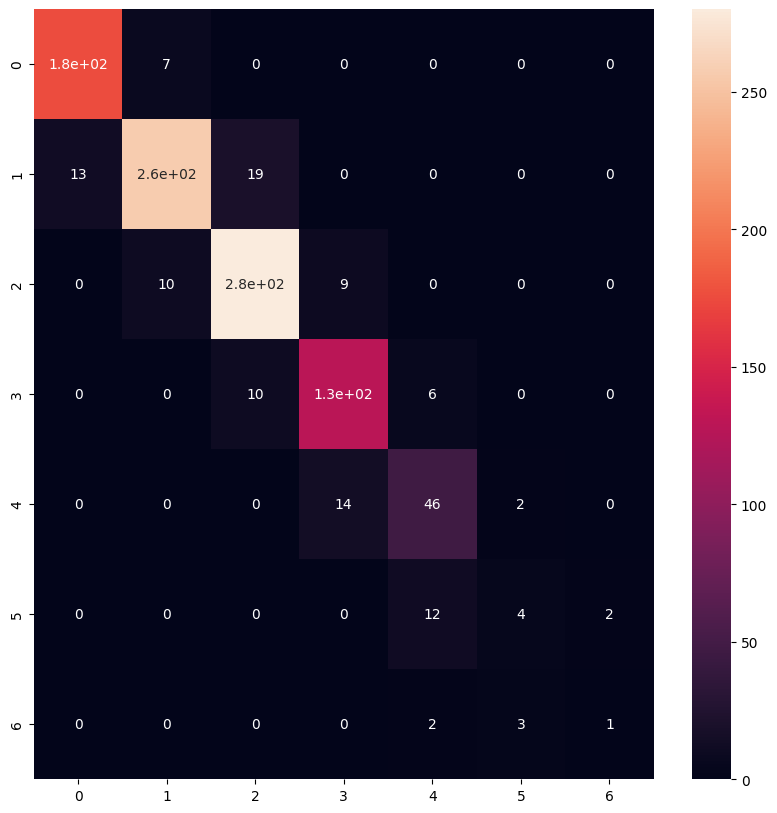

In [193]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

In [201]:
print(results.head())

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.985582      0.287254         0.009019        0.003099   
1       2.096229      0.696078         0.010011        0.003600   
2       2.786564      0.339143         0.007590        0.000256   
3       1.623941      0.293374         0.007420        0.000533   
4       8.118582      2.948401         0.025720        0.005282   

  param_activation param_hidden_layer_sizes  param_learning_rate_init  \
0             relu                 (16, 16)                     0.001   
1             relu                 (16, 16)                     0.010   
2             relu                 (16, 32)                     0.001   
3             relu                 (16, 32)                     0.010   
4             relu             (16, 32, 64)                     0.001   

  param_solver                                             params  \
0         adam  {'activation': 'relu', 'hidden_layer_sizes': (...   
1         adam  {'ac

In [203]:
results = pd.DataFrame(grid.cv_results_)
results_df = results[['param_activation', 'param_hidden_layer_sizes', 'param_learning_rate_init',
                      'param_solver']]
print(results_df.head())

  param_activation param_hidden_layer_sizes  param_learning_rate_init  \
0             relu                 (16, 16)                     0.001   
1             relu                 (16, 16)                     0.010   
2             relu                 (16, 32)                     0.001   
3             relu                 (16, 32)                     0.010   
4             relu             (16, 32, 64)                     0.001   

  param_solver  
0         adam  
1         adam  
2         adam  
3         adam  
4         adam  


#### Another Parameter Settings 1

In [214]:
chosen_params = results.loc[5, 'params']
chosen_params


{'activation': 'relu',
 'hidden_layer_sizes': (16, 32, 64),
 'learning_rate_init': 0.01,
 'solver': 'adam'}

In [217]:
model = MLPClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.906
Precision: 0.9048884026249193
Recall: 0.906
F1 Score: 0.9047136452451086


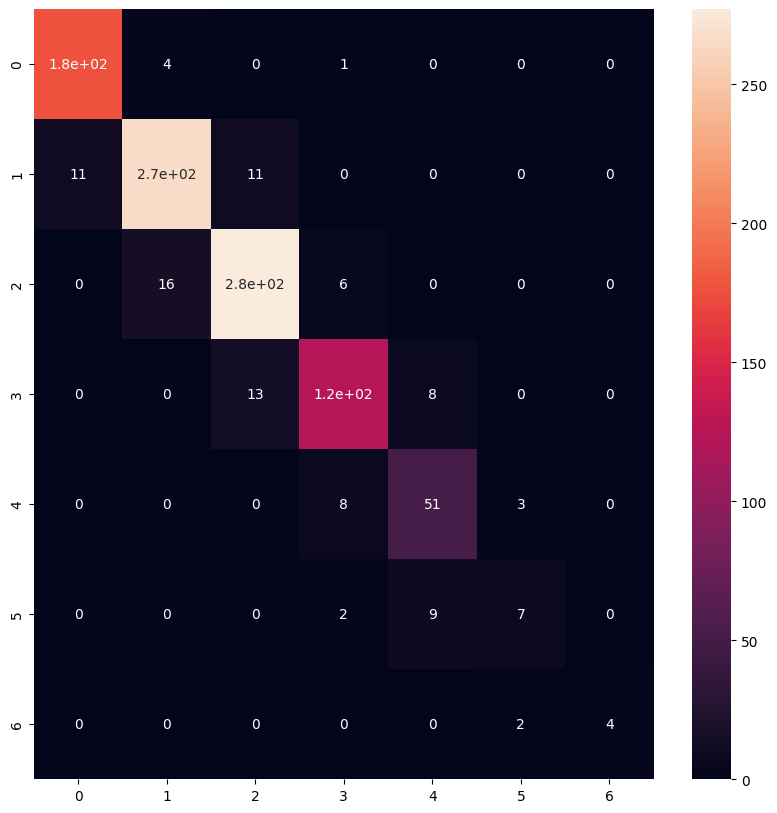

In [218]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

##### Another Parameter settings 2

In [211]:
chosen_params = results.loc[7, 'params']
chosen_params

{'activation': 'relu',
 'hidden_layer_sizes': (16, 32, 32),
 'learning_rate_init': 0.01,
 'solver': 'adam'}

In [212]:
model = MLPClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.881
Precision: 0.8850851275079434
Recall: 0.881
F1 Score: 0.882627476534929


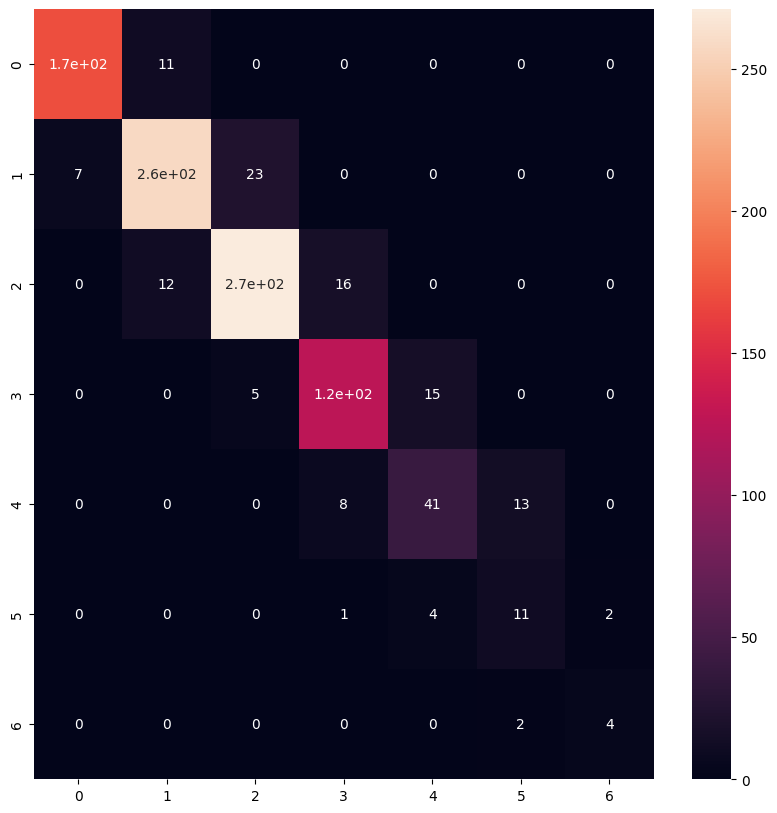

In [213]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### With Holdout

In [222]:


mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(16,16), (16,32), (16, 32 , 64), (16 , 32 , 32)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
}

test_fold = [-1] * int(len(X_train) * 0.8) + [0] * int(len(X_train) * 0.2)
ps = PredefinedSplit(test_fold)

grid = GridSearchCV(
    mlp,
    param_grid,
    cv=ps,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)

Fitting 1 folds for each of 8 candidates, totalling 8 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.894


In [223]:
print(grid.best_params_)

{'activation': 'relu', 'hidden_layer_sizes': (16, 16), 'learning_rate_init': 0.01, 'solver': 'adam'}


In [224]:
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8952671817846236
Recall: 0.894
F1 Score: 0.8941571431749084


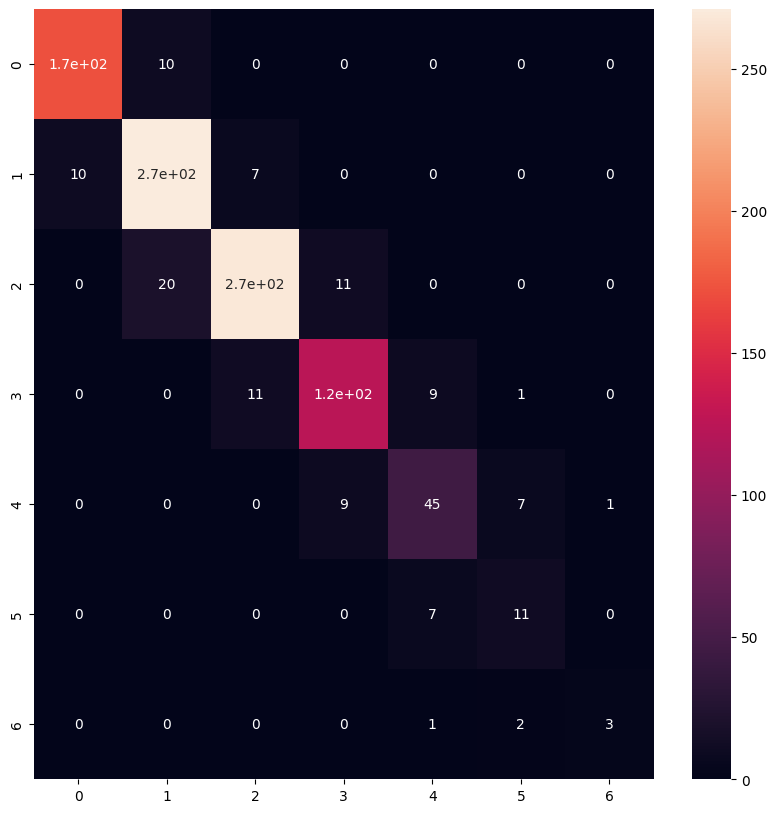

In [225]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

In [226]:
results = pd.DataFrame(grid.cv_results_)
results_df = results[['param_activation', 'param_hidden_layer_sizes', 'param_learning_rate_init',
                      'param_solver']]
print(results_df.head())

  param_activation param_hidden_layer_sizes  param_learning_rate_init  \
0             relu                 (16, 16)                     0.001   
1             relu                 (16, 16)                     0.010   
2             relu                 (16, 32)                     0.001   
3             relu                 (16, 32)                     0.010   
4             relu             (16, 32, 64)                     0.001   

  param_solver  
0         adam  
1         adam  
2         adam  
3         adam  
4         adam  


#### Another Parameter Settings 1

In [227]:
chosen_params = results.loc[5, 'params']
chosen_params

{'activation': 'relu',
 'hidden_layer_sizes': (16, 32, 64),
 'learning_rate_init': 0.01,
 'solver': 'adam'}

In [228]:
model = MLPClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.886
Precision: 0.880861575617705
Recall: 0.886
F1 Score: 0.8831209631713817


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


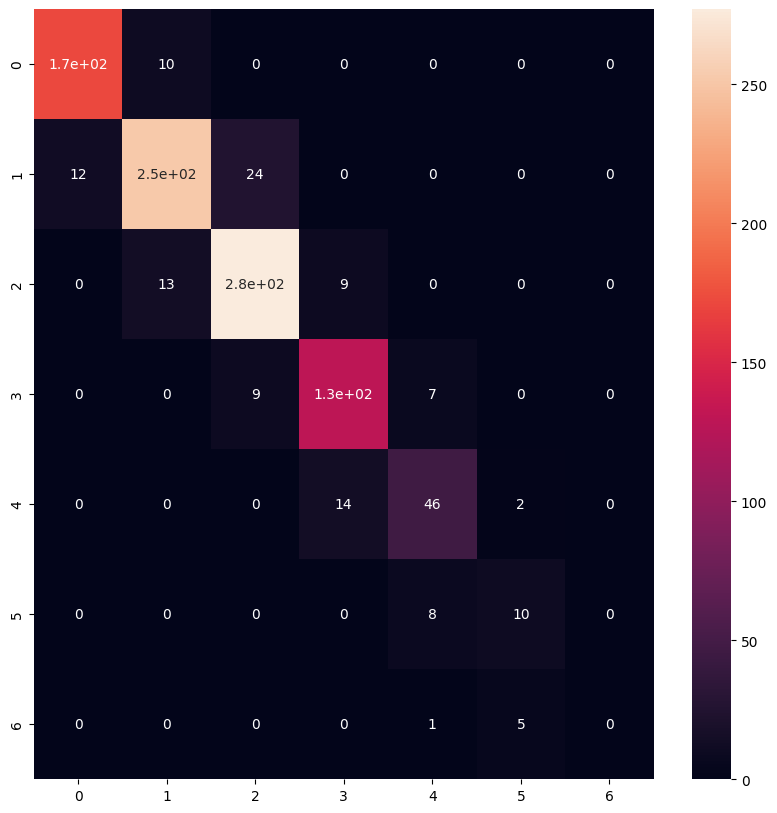

In [229]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

#### Another Parametere Setting 2

In [230]:
chosen_params = results.loc[7, 'params']
chosen_params

{'activation': 'relu',
 'hidden_layer_sizes': (16, 32, 32),
 'learning_rate_init': 0.01,
 'solver': 'adam'}

In [231]:
model = MLPClassifier(**chosen_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Model Accuracy: 0.908
Precision: 0.9077021956612387
Recall: 0.908
F1 Score: 0.9058364631356187


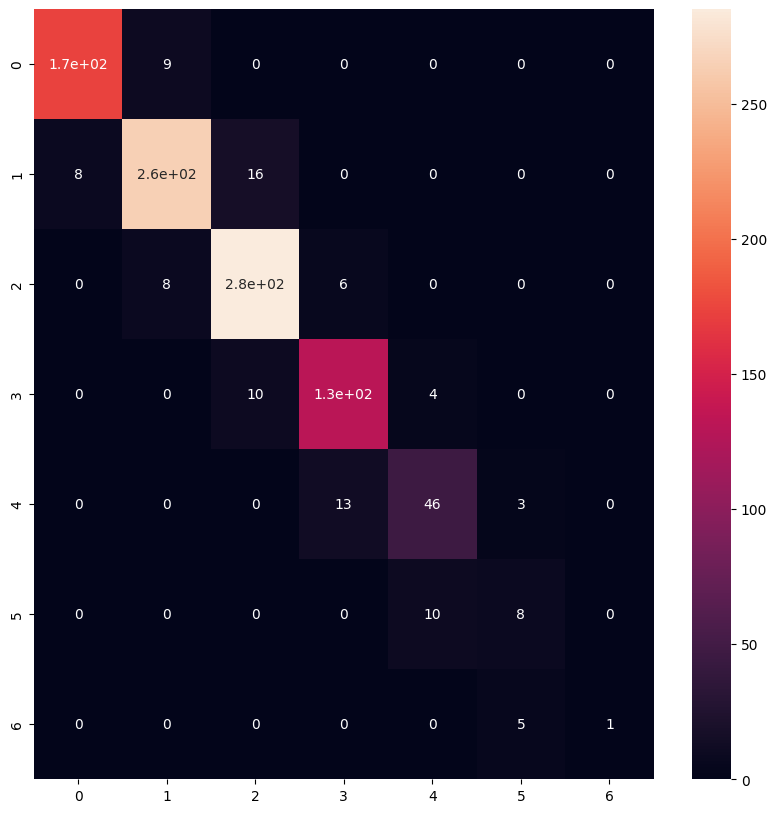

In [232]:
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

## Random Forest